# Labeled Faces in the Wild

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

## Benchmark model using SVM eigenface

Example model from scikit-learn, extended to more people with fewer face images

Include people with a minimum of 25 face images

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=25, resize=0.5)

X_data = lfw_people.data
X_images = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_samples, h, w = lfw_people.images.shape

In [3]:
X_train_, X_test, y_train_, y_test = train_test_split(X_data, y, test_size=0.2, random_state=8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=0.2, random_state=8)
print X_train.shape, y_train.shape
print X_valid.shape, y_valid.shape
print X_test.shape, y_test.shape

(1656, 2914) (1656,)
(414, 2914) (414,)
(518, 2914) (518,)


In [4]:
n_components = 150

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))

In [5]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

The most significative eigenfaces

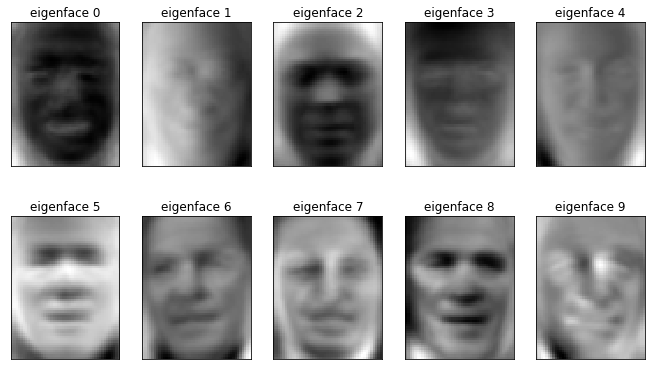

In [6]:
%matplotlib inline 
from matplotlib import pyplot as plt
def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.6 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

Train a SVM classification model


In [7]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1, 5, 1e1, 5e1, 1e2, 5e2, 1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print(clf.best_params_)

Fitting the classifier to the training set
{'C': 10.0, 'gamma': 0.001}


Quantitative evaluation of the model quality on the test set


In [9]:
print("Predicting people's names on the test set")
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

Predicting people's names on the test set
                           precision    recall  f1-score   support

         Alejandro Toledo       1.00      0.50      0.67        10
             Alvaro Uribe       0.50      0.57      0.53         7
             Andre Agassi       0.88      0.70      0.78        10
             Ariel Sharon       0.69      0.50      0.58        18
    Arnold Schwarzenegger       0.22      0.20      0.21        10
             Bill Clinton       0.50      0.62      0.56         8
             Colin Powell       0.79      0.73      0.76        51
            David Beckham       0.33      0.17      0.22         6
          Donald Rumsfeld       0.38      0.89      0.53        19
            George W Bush       0.82      0.79      0.81       107
        Gerhard Schroeder       0.42      0.68      0.52        19
  Gloria Macapagal Arroyo       0.75      0.75      0.75         8
               Gray Davis       0.33      0.12      0.18         8
          Guillermo

In [11]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

#print "Accuracy: ", round(accuracy_score(y_test, y_pred)*100, 1),'%'
print "Precision: ", round(precision_score(y_test, y_pred, average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(y_test, y_pred, average='weighted')*100, 1) ,'%' 

Precision:  64.7 %
Recall:  62.4 %


## Train a CNN model with the same dataset

### Prepare the dataset

In [45]:
lfw_people = fetch_lfw_people(min_faces_per_person=25, resize=0.5)
X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names

In [46]:
from keras.utils import np_utils
X = X.reshape(-1, X.shape[1], X.shape[2], 1)
y = np_utils.to_categorical(y, 42)

X = X.astype('float32')
X = X / 255.0

In [47]:
X_train_, X_test, y_train_, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_, y_train_, test_size=0.2, random_state=8)
print X_train.shape, y_train.shape
print X_valid.shape, y_valid.shape
print X_test.shape, y_test.shape

(1656, 62, 47, 1) (1656, 42)
(414, 62, 47, 1) (414, 42)
(518, 62, 47, 1) (518, 42)


### Build the model

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam

In [37]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(62, 47, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
        
model.add(Convolution2D(32, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
    
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(42, activation='softmax'))

In [38]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_10 (Convolution2D) (None, 62, 47, 32)    320         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 62, 47, 32)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
maxpooling2d_10 (MaxPooling2D)   (None, 31, 23, 32)    0           activation_10[0][0]              
____________________________________________________________________________________________________
dropout_16 (Dropout)             (None, 31, 23, 32)    0           maxpooling2d_10[0][0]            
___________________________________________________________________________________________

### Train the model
intermediate processes omitted

In [36]:
#epochs = 40
#lrate = 0.000001
#decay = lrate/epochs
#adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size= 32, nb_epoch= 10, verbose=2, validation_data=(X_valid, y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
17s - loss: 0.2986 - acc: 0.9076 - val_loss: 0.9351 - val_acc: 0.7657
Epoch 2/10
16s - loss: 0.2757 - acc: 0.9173 - val_loss: 0.9350 - val_acc: 0.7657
Epoch 3/10
16s - loss: 0.2469 - acc: 0.9179 - val_loss: 0.9349 - val_acc: 0.7657
Epoch 4/10
18s - loss: 0.2750 - acc: 0.9070 - val_loss: 0.9343 - val_acc: 0.7657
Epoch 5/10
17s - loss: 0.2468 - acc: 0.9130 - val_loss: 0.9337 - val_acc: 0.7657
Epoch 6/10
17s - loss: 0.2484 - acc: 0.9215 - val_loss: 0.9336 - val_acc: 0.7657
Epoch 7/10
17s - loss: 0.2783 - acc: 0.9124 - val_loss: 0.9337 - val_acc: 0.7657
Epoch 8/10
17s - loss: 0.2667 - acc: 0.9209 - val_loss: 0.9334 - val_acc: 0.7657
Epoch 9/10
16s - loss: 0.3008 - acc: 0.8992 - val_loss: 0.9333 - val_acc: 0.7657
Epoch 10/10
17s - loss: 0.2783 - acc: 0.9130 - val_loss: 0.9330 - val_acc: 0.7657


### Performance on the test dataset

In [48]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

y_pred = model.predict(X_test)
#print "Accuracy: ", round(accuracy_score(y_test.argmax(1), y_pred.argmax(1))*100,1),'%'
print "Precision: ", round(precision_score(y_test.argmax(1), y_pred.argmax(1), average='weighted')*100,1), '%'  
print "Recall: ", round(recall_score(y_test.argmax(1), y_pred.argmax(1), average='weighted')*100,1),'%'

Precision:  81.2 %
Recall:  80.3 %


In [49]:
model.save('second_model0309.h5')

In [50]:
n_classes = target_names.shape[0]
y_pred = y_pred.argmax(-1)
y_test = y_test.argmax(-1)

print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.86      0.60      0.71        10
             Alvaro Uribe       0.80      0.57      0.67         7
             Andre Agassi       0.80      0.80      0.80        10
             Ariel Sharon       0.82      0.78      0.80        18
    Arnold Schwarzenegger       0.43      0.30      0.35        10
             Bill Clinton       0.89      1.00      0.94         8
             Colin Powell       0.93      0.84      0.89        51
            David Beckham       0.57      0.67      0.62         6
          Donald Rumsfeld       0.72      0.95      0.82        19
            George W Bush       0.89      0.98      0.93       107
        Gerhard Schroeder       0.68      0.79      0.73        19
  Gloria Macapagal Arroyo       0.86      0.75      0.80         8
               Gray Davis       1.00      0.75      0.86         8
          Guillermo Coria       0.33      0.14      0.20     

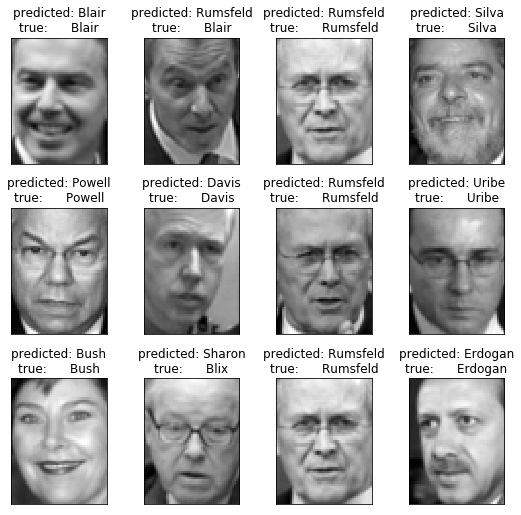

In [55]:
from matplotlib import pyplot as plt
%matplotlib inline
import random

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        rnd = random.randint(0, len(images)-1)
        plt.imshow(images[i+rnd].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i+rnd], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

h = 62
w = 47
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
plt.show()